In [ ]:
import numpy as np 
import pandas as pd 
import keras
from keras.models import Sequential
from keras.layers import Conv2D, Flatten, Dense, MaxPooling2D, Dropout,BatchNormalization
from sklearn.metrics import accuracy_score
import ipywidgets as widgets
import io
import os
from PIL import Image
import tqdm
from sklearn.model_selection import train_test_split
import cv2
from sklearn.utils import shuffle
import tensorflow as tf
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt


In [ ]:
X_train = []
y_train = []
X_test = []
y_test = []
image_size = 150

In [ ]:
train_path = 'C:\\Users\\mvams\\OneDrive\\Desktop\\Nanda Paper\\Execution\\New_Data\\Train'
labels = os.listdir(train_path)
print(labels)
print(len(labels))

['Alzheimer-MildDemented', 'Alzheimer-ModerateDemented', 'Alzheimer-NonDemented', 'Alzheimer-VeryMildDemented', 'Brain_Tumor-glioma_tumor', 'Brain_Tumor-glioma_tumor-meningioma_tumor', 'Brain_Tumor-glioma_tumor-pituitary_tumor', 'Healthy_Brain', 'Multiple Sclerosis-Control-Axial', 'Multiple Sclerosis-Control-Sagittal', 'Multiple Sclerosis-MS-Axial', 'Multiple Sclerosis-MS-Sagittal']
12


In [ ]:
for i in labels:
    folder_path = os.path.join(train_path, i)
    for j in os.listdir(folder_path):
        img = cv2.imread(os.path.join(folder_path, j))
        img = cv2.resize(img, (image_size, image_size))
        
        X_train.append(img)
        y_train.append(i)

In [ ]:
test_path =  'C:\\Users\\mvams\\OneDrive\\Desktop\\Nanda Paper\\Execution\\New_Data\\Test'
for i in labels:
    folder_path = os.path.join(test_path, i)
    for j in os.listdir(folder_path):
        img = cv2.imread(os.path.join(folder_path, j))
        img = cv2.resize(img, (image_size, image_size))
        
        X_test.append(img)
        y_test.append(i)

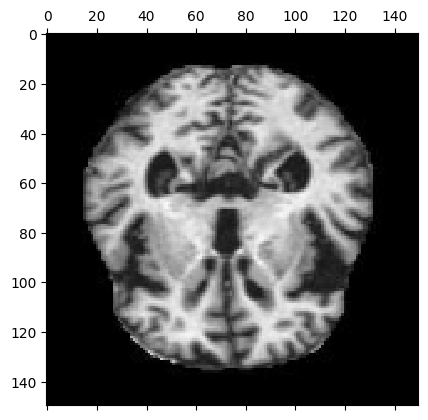

In [ ]:
import matplotlib.pyplot as plt
plt.matshow(X_train[1])


In [ ]:
# X_train.shape, y_train.shape
len(X_train), len(y_train)

(11418, 11418)

In [ ]:
X_train = np.array(X_train)
y_train = np.array(y_train)

In [ ]:
X_train.shape, y_train.shape

((11418, 150, 150, 3), (11418,))

In [ ]:
X_train, y_train = shuffle(X_train, y_train, random_state = 99)
X_train.shape, y_train.shape

((11418, 150, 150, 3), (11418,))

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size = 0.2, random_state = 100)

In [ ]:
y_train[:5]

array(['Brain_Tumor-glioma_tumor-meningioma_tumor',
       'Alzheimer-VeryMildDemented', 'Brain_Tumor-glioma_tumor',
       'Alzheimer-NonDemented',
       'Brain_Tumor-glioma_tumor-meningioma_tumor'], dtype='<U41')

In [ ]:
len(X_test)

2284

In [ ]:
y_train_new = []
for i in y_train:
    y_train_new.append(labels.index(i))

y_train_new[:5]

[5, 3, 4, 2, 5]

In [ ]:
y_train_new = tf.keras.utils.to_categorical(y_train_new)
y_train_new

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.]], dtype=float32)

In [ ]:
y_test_new = []
for i in y_test:
    y_test_new.append(labels.index(i))

y_test_new = tf.keras.utils.to_categorical(y_test_new)
y_test_new

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [ ]:
# add preprocessing layer to the front of VGG
vgg = VGG16(input_shape=[150,150] + [3], weights='imagenet', include_top=False)


In [ ]:
# don't train existing weights
for layer in vgg.layers:
  layer.trainable = False

In [ ]:
x = Flatten()(vgg.output)
x = BatchNormalization()(x)
x = Dropout(0.8)(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.8)(x)
prediction = Dense(len(labels), activation='softmax')(x)

In [ ]:
# create a model object
model = Model(inputs=vgg.input, outputs=prediction)

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

In [ ]:
# tell the model what cost and optimization method to use
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

In [ ]:
# fit the model
hist = model.fit(X_train, y_train_new, epochs = 30, validation_split = 0.1)

Epoch 1/30
257/257 [==============================] - 57s 164ms/step - loss: 1.7291 - accuracy: 0.5313 - val_loss: 0.7136 - val_accuracy: 0.7035
Epoch 2/30
257/257 [==============================] - 34s 134ms/step - loss: 1.0781 - accuracy: 0.6162 - val_loss: 0.5967 - val_accuracy: 0.7604
Epoch 3/30
257/257 [==============================] - 35s 135ms/step - loss: 0.8778 - accuracy: 0.6519 - val_loss: 0.5853 - val_accuracy: 0.7571
Epoch 4/30
257/257 [==============================] - 35s 135ms/step - loss: 0.8173 - accuracy: 0.6646 - val_loss: 0.5692 - val_accuracy: 0.7670
Epoch 5/30
257/257 [==============================] - 35s 135ms/step - loss: 0.7636 - accuracy: 0.6797 - val_loss: 0.5843 - val_accuracy: 0.7593
Epoch 6/30
257/257 [==============================] - 35s 135ms/step - loss: 0.7353 - accuracy: 0.6869 - val_loss: 0.5730 - val_accuracy: 0.7440
Epoch 7/30
257/257 [==============================] - 35s 135ms/step - loss: 0.7242 - accuracy: 0.6933 - val_loss: 0.5522 - val_ac

In [ ]:
model.save("Brain_Disease_Classification_Using_VGG16_Model.h5")

In [ ]:
acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy'] 

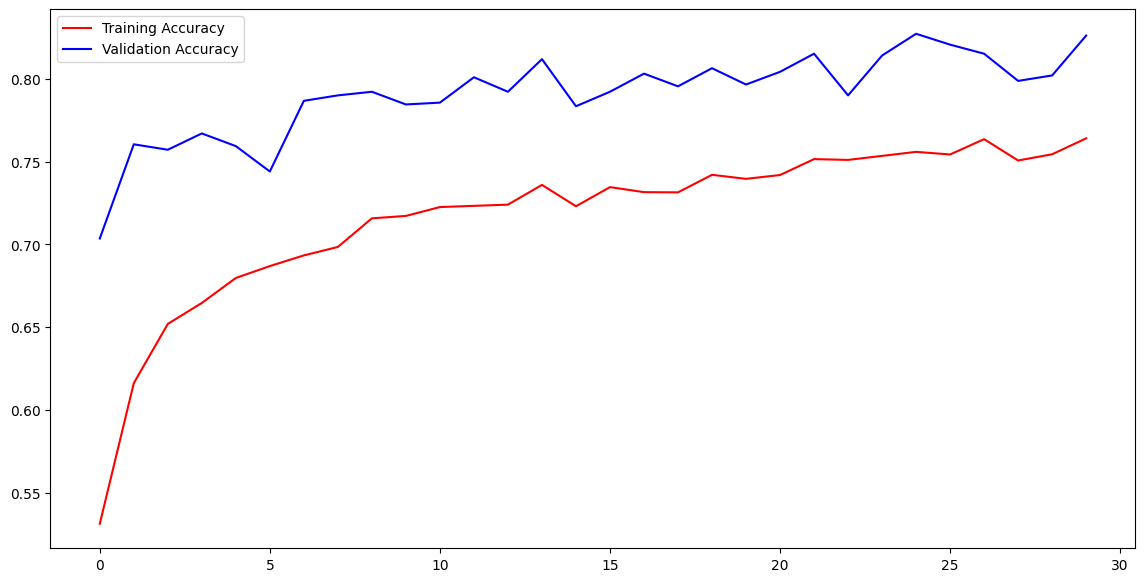

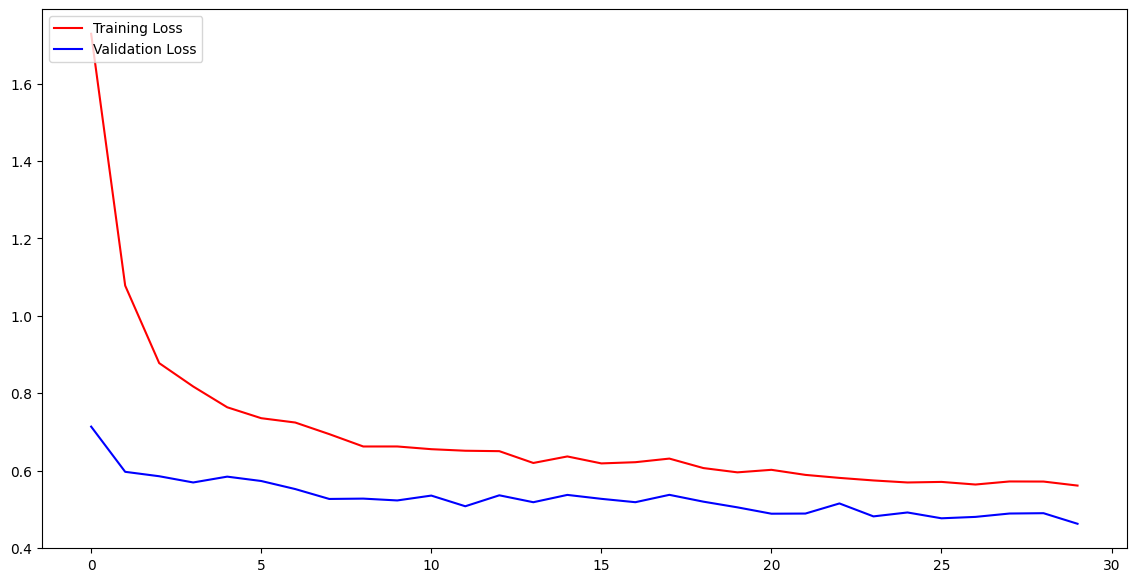

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

epochs = range(len(acc))
fig = plt.figure(figsize = (14,7))
plt.plot(epochs, acc, 'r', label = 'Training Accuracy')
plt.plot(epochs, val_acc, 'b', label = 'Validation Accuracy')
plt.legend(loc = 'upper left')
plt.show()

loss = hist.history['loss']
val_loss = hist.history['val_loss'] 

epochs = range(len(acc))
fig = plt.figure(figsize = (14,7))
plt.plot(epochs, loss, 'r', label = 'Training Loss')
plt.plot(epochs, val_loss, 'b', label = 'Validation Loss')
plt.legend(loc = 'upper left')
plt.show()

In [ ]:
loss,acc = model.evaluate(X_test,y_test_new)

72/72 [==============================] - 11s 151ms/step - loss: 0.4782 - accuracy: 0.8056
